In [63]:
import torch
from torch import nn 
import numpy as np
import timm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import os
from tqdm.autonotebook import tqdm


In [64]:
model = timm.create_model("hf_hub:timm/eva_large_patch14_336.in22k_ft_in22k_in1k", pretrained=True,num_classes=3)

In [65]:
model = timm.create_model('mobilevitv2_075.cvnets_in1k', pretrained=True,num_classes=3)

In [66]:
model.get_classifier()

Linear(in_features=384, out_features=3, bias=True)

In [67]:
num_in_feat = model.get_classifier().in_features
model.fc = nn.Sequential(nn.BatchNorm1d(num_in_feat),
                         nn.Linear(in_features=num_in_feat,out_features=512),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(0.4),
                         nn.Linear(in_features=512,out_features=3))

In [68]:
class SwanDataset(Dataset):
    def __init__(self,path_to_folder,transforms=None) -> None:
        super().__init__()
        self.file_names = os.listdir(path_to_folder)
        self.data_folder = path_to_folder
        self.transforms = transforms

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        path = os.path.join(self.data_folder,self.file_names[index])
        img = Image.open(path)
        if self.transforms:
            img = self.transforms(img)
        return (img, 2)

In [69]:
tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])
swans = SwanDataset('./train_dataset_Минприроды/разметка_шипун/images/',tr)

dataloader = DataLoader(swans,batch_size=4,shuffle=True)

In [73]:
def train(model,dataloader,optimizer,criterion,device,epochs=1):
    avg_loss_history = []
    full_loss_history  = []
    for _ in tqdm(range(epochs)):
        
        batch_loss_history = []

        for data in tqdm(dataloader):
            imgs,labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)

            outs = model(imgs)

            loss = criterion(outs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            full_loss_history.append(loss.item())
            batch_loss_history.append(loss.item())

        avg_batch_loss = np.mean(batch_loss_history)
        print(f'Loss on epoch = {avg_batch_loss}')
        
        avg_loss_history.append(avg_batch_loss)
    return full_loss_history,avg_loss_history

In [74]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=1e-4,)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [75]:
full_loss,avg_loss = train(model,dataloader,optimizer=opt,criterion=criterion,device=device,epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

Loss on epoch = 0.00653690766344641


  0%|          | 0/753 [00:00<?, ?it/s]

Loss on epoch = 0.0005231314262370288


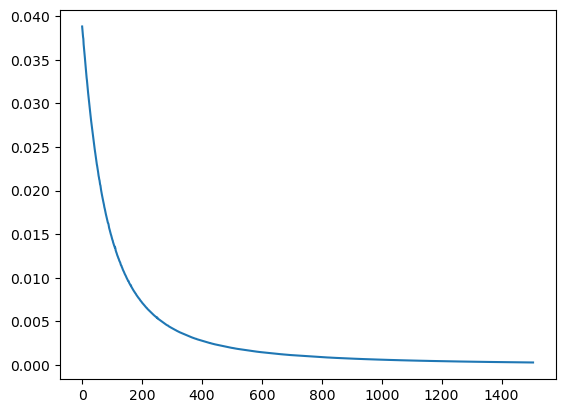

In [76]:
import matplotlib.pyplot as plt

plt.plot(full_loss)

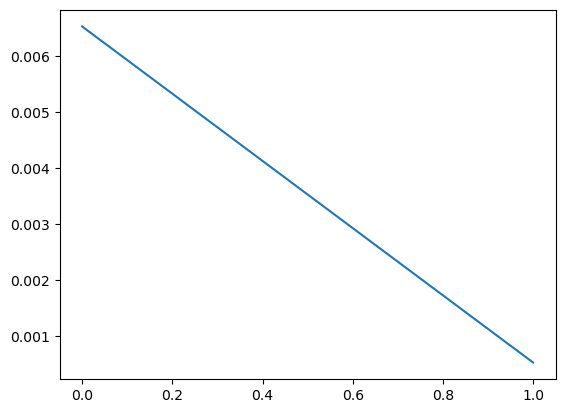

In [77]:
plt.plot(avg_loss)